# Projet 5 - Segmentez des clients d'un site e-commerce (Partie 2)

> 🎓 OpenClassrooms • Parcours [AI Engineer](https://openclassrooms.com/fr/paths/795-ai-engineer) | 👋 *Etudiant* : [David Scanu](https://www.linkedin.com/in/davidscanu14/)

## 📊 Partie 3 : Simulation et maintenance

Dans ce notebook, nous allons explorer la dynamique des clusters au fil du temps et déterminer la **fréquence optimale de mise à jour** pour notre modèle de segmentation. En simulant l'évolution des clusters, nous pourrons **identifier les changements significatifs** qui nécessitent une **mise à jour du modèle**. Enfin, nous proposerons un **plan de maintenance efficace**.

## ⚡ Mission

Nous sommes **consultant pour Olist** et nous avons été chargé de **réaliser cette segmentation**, en mettant en place des modèles d'**apprentissage non supervisé** et en fournissant un **plan de maintenance** du modèle.

In [16]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from datetime import datetime

In [17]:
# Set display options to show the DataFrame in full width
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

## Chargement commandes

Nous chargeons les commandes précedemment exportées depuis le notebook `p05-david_scanu_02_notebook_exploration_20250117.ipynb`.


In [18]:
data_dir = './content/data'
processed_orders = pd.read_csv(os.path.join(data_dir, 'processed_orders.csv'))
processed_orders.head()

,order_id,order_purchase_timestamp,customer_unique_id,payment_value,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,38.71,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,141.46,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,179.12,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,72.20,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,28.62,5.0


In [19]:
processed_orders.dtypes

order_id                     object
order_purchase_timestamp     object
customer_unique_id           object
payment_value               float64
review_score                float64
dtype: object

## Création des données "client"

Nous créons, à partir des commandes, les **données clients** contenant les colonnes suivantes : 

- `customer_unique_id` : Identifiant unique du client.
- `recency` : Nombre de jours depuis la dernière commande.
- `frequency` : Nombre de commandes passées par le client.
- `monetary` : Montant total dépensé par le client.
- `avg_review_score` : Score moyen des avis laissés par le client.

Nous choisissons l'année `2017` comme période de référence pour effectuer une segmentation de base (baseline). Nous étudierons ensuite l'évolution des clusters en ajoutant des données trimestrielles.

In [20]:
def create_rfm_df(df, start_date = datetime(2017, 1, 1), end_date = datetime(2017, 12, 31, 23, 59, 59), verbose=True):
    """
    Fonction pour créer les colonnes RFM (Récence, Fréquence, Montant) et score de satisfaction à partir des commandes.

    Args:
    - df (pd.DataFrame): Le DataFrame contenant les commandes.

    Returns:
    - pd.DataFrame: Le DataFrame contenant les colonnes RFM et score de satisfaction.
    """
    # Convertir la colonne 'order_purchase_timestamp' au format datetime
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
    # Filtrer les commandes pour la période spécifiée
    df = df[(df['order_purchase_timestamp'] >= start_date) & (df['order_purchase_timestamp'] <= end_date)]

    if verbose:
        print("Nombre de commandes : ", df.shape[0])
        print("Nombre de clients uniques :", df['customer_unique_id'].nunique())
        print("Période : ", start_date, " à ", end_date)
        print("Date de la première commande :", df['order_purchase_timestamp'].min())
        print("Date de la dernière commande :", df['order_purchase_timestamp'].max())
        print()

    # Si des commandes existents
    if not df.empty:

        # Créer une table pivot pour RFM
        rfm_df = df.pivot_table(
            index='customer_unique_id',
            values='order_purchase_timestamp',
            aggfunc={'order_purchase_timestamp': 'max'}
        )

        rfm_df.rename(columns={'order_purchase_timestamp': 'most_recent_purchase'}, inplace=True)

        period_end_timestamp = pd.Timestamp(end_date)

        rfm_df['recency'] = (period_end_timestamp - rfm_df['most_recent_purchase']).dt.days
        rfm_df['frequency'] = df.groupby('customer_unique_id').size()
        rfm_df['monetary'] = df.groupby('customer_unique_id')['payment_value'].sum()
        rfm_df['avg_review_score'] = df.groupby('customer_unique_id')['review_score'].mean()

        rfm_df = rfm_df.drop(columns='most_recent_purchase')

        return rfm_df

    else:
        print(f"Aucune commandes trouvées pour la période : {start_date} à {end_date}")
        return None

### Données client pour l'année 2017

In [21]:
rfm_baseline = create_rfm_df(processed_orders)
print("Données RFM+S :", rfm_baseline.shape)
print(rfm_baseline.head(10))

Nombre de commandes :  43100
Nombre de clients uniques : 41824
Période :  2017-01-01 00:00:00  à  2017-12-31 23:59:59
Date de la première commande : 2017-01-05 11:56:06
Date de la dernière commande : 2017-12-31 23:29:31

Données RFM+S : (41824, 4)
                                  recency  frequency  monetary  avg_review_score
customer_unique_id                                                              
0000f46a3911fa3c0805444483337064      296          1     86.22               3.0
0000f6ccb0745a6a4b88665a16c9f078       80          1     43.62               4.0
0004aac84e0df4da2b147fca70cf8255       47          1    196.89               5.0
0005e1862207bf6ccc02e4228effd9a0      302          1    150.12               4.0
0006fdc98a402fceb4eb0ee528f6a8d4      166          1     29.00               3.0
00082cbe03e478190aadbea78542e933       42          1    126.26               5.0
000a5ad9c4601d2bbdd9ed765d5213b3      142          1     91.28               4.0
000bfa1d2f1a41876493be6

Nous vérifions que nos données RFM+S ne contiennent pas de valeurs manquantes.

## Prétraitement variables

In [22]:
from sklearn.preprocessing import StandardScaler

# Preprocessing: scale features
features = ['recency', 'frequency', 'monetary', 'avg_review_score']
scaler = StandardScaler()
X_baseline = scaler.fit_transform(rfm_baseline[features])
print(X_baseline.shape)

(41824, 4)


## Clustering non supervisé

Nous calculons le clustering pour 7 clusters avec la méthode `KMeans`, pour l'année `2017`. 

In [23]:
%%time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Train k-means on baseline data
k = 7  # or choose via domain knowledge / elbow method
kmeans_baseline = KMeans(n_clusters=k, random_state=42, n_init=10)
rfm_baseline['cluster'] = kmeans_baseline.fit_predict(X_baseline)


# Save the baseline model parameters: scaler and cluster centers
baseline_centers = kmeans_baseline.cluster_centers_

CPU times: user 5.86 s, sys: 229 ms, total: 6.09 s
Wall time: 1.07 s


In [24]:
rfm_baseline.head()

,recency,frequency,monetary,avg_review_score,cluster
customer_unique_id,,,,,
0000f46a3911fa3c0805444483337064,296,1,86.22,3.0,2
0000f6ccb0745a6a4b88665a16c9f078,80,1,43.62,4.0,0
0004aac84e0df4da2b147fca70cf8255,47,1,196.89,5.0,0
0005e1862207bf6ccc02e4228effd9a0,302,1,150.12,4.0,1
0006fdc98a402fceb4eb0ee528f6a8d4,166,1,29.00,3.0,2


In [25]:
baseline_distribution_abs = rfm_baseline['cluster'].value_counts().sort_index()
baseline_distribution_rel = rfm_baseline['cluster'].value_counts(normalize=True).sort_index() * 100
baseline_distribution_rel = baseline_distribution_rel.round(4)
# Combine the absolute and relative distributions into a single DataFrame
baseline_distribution = pd.DataFrame({
    'count': baseline_distribution_abs,
    'proportion': baseline_distribution_rel
})
print(baseline_distribution)

         count  proportion
cluster                   
0        18231     43.5898
1        12709     30.3869
2         3302      7.8950
3         4850     11.5962
4         1149      2.7472
5          174      0.4160
6         1409      3.3689


In [26]:
# Compute baseline quality metrics
baseline_inertia = kmeans_baseline.inertia_
baseline_silhouette = silhouette_score(X_baseline, rfm_baseline['cluster'])
baseline_dbi = davies_bouldin_score(X_baseline, rfm_baseline['cluster'])
baseline_chi = calinski_harabasz_score(X_baseline, rfm_baseline['cluster'])

print("Métriques du clustering nBaseline :")
print("Inertie:", baseline_inertia)
print("Score Silhouette :", baseline_silhouette)
print("Indice de Davies-Bouldin (DBI) :", baseline_dbi)
print("Indice de Calinski-Harabasz :", baseline_chi)

Métriques du clustering nBaseline :
Inertie: 42620.236898764946
Score Silhouette : 0.4323527965094292
Indice de Davies-Bouldin (DBI) : 0.8344088100244075
Indice de Calinski-Harabasz : 20387.684106212724


### Analyse de la Stabilité des Segments et Détection de la Dérive

Nous analysons la stabilité des segments au fil du temps pour déterminer la fréquence optimale de mise à jour du modèle de segmentation. Voici les indicateurs utilisés :

1. **Indicateurs de Qualité du Clustering :**
   - **Inertie (Inertia)** : Mesure la somme des distances au carré entre chaque point et le centre de son cluster. Une augmentation significative de l'inertie peut indiquer une dérive dans la structure des données.
   - **Silhouette Score** : Évalue la cohésion et la séparation des clusters. Une diminution de ce score peut signaler une détérioration de la qualité du clustering.

2. **Indicateurs de Stabilité des Clusters :**
   - **Indice de Rand Ajusté (ARI)** : Compare les étiquettes des clusters entre deux périodes pour mesurer leur similarité. Un ARI élevé indique une stabilité des clusters.
   - **Homogénéité** : Mesure si chaque cluster contient seulement des points d'une même classe. Une homogénéité élevée signifie que les clusters sont bien définis.
   - **Complétude** : Évalue si tous les points d'une même classe sont assignés au même cluster. Une complétude élevée indique que les clusters capturent bien les classes sous-jacentes.

3. **Indicateurs de Distribution des Caractéristiques :**
   - **Test de Kolmogorov-Smirnov (KS)** : Compare la distribution des caractéristiques entre les périodes pour détecter des changements significatifs. Un test KS avec une faible p-valeur indique une différence notable dans la distribution des données.

4. **Indicateurs de Dérive des Centres de Clusters :**
   - **Distance des Centres de Clusters** : Mesure la distance euclidienne entre les centres des clusters de la période de référence et ceux de la nouvelle période. Une grande distance peut indiquer une dérive des clusters.


Ces indicateurs permettent de surveiller la stabilité des segments et de déterminer quand une mise à jour du modèle est nécessaire pour maintenir sa pertinence.

*Attention* : L'année 2018 s'arrète au mois d'aout.

In [ ]:
processed_orders['order_purchase_timestamp'].max()

Timestamp('2018-08-29 15:00:37')

In [ ]:
# 3 premiers trimestres de 2018
# monitor_dates = [datetime(2018, 3, 31, 23, 59, 59), datetime(2018, 6, 30, 23, 59, 59), datetime(2018, 9, 30, 23, 59, 59)]

# List of datetime for each month till September 2018
monitor_dates = [
    datetime(2018, 1, 31, 23, 59, 59),
    datetime(2018, 2, 28, 23, 59, 59),
    datetime(2018, 3, 31, 23, 59, 59),
    datetime(2018, 4, 30, 23, 59, 59),
    datetime(2018, 5, 31, 23, 59, 59),
    datetime(2018, 6, 30, 23, 59, 59),
    datetime(2018, 7, 31, 23, 59, 59),
    datetime(2018, 8, 31, 23, 59, 59)
]

In [27]:
%%time
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score
from scipy.stats import ks_2samp

print("\n--- Monitoring for Drift ---")

for monitor_date in monitor_dates:
    print(f"\n--- Monitoring at period end: {monitor_date.date()} ---")
    # Aggregate new RFM data for current period
    rfm_new = create_rfm_df(processed_orders, end_date=monitor_date)
    
    # Align customers: use intersection of baseline and new customers for label-based comparisons
    common_customers = rfm_baseline.index.intersection(rfm_new.index)
    # print("Common Customers:", len(common_customers))
    rfm_new = rfm_new.loc[common_customers]
    # print("New RFM Shape (after alignment):", rfm_new.shape)
    X_new = scaler.transform(rfm_new[features])
    
    # Option 1: Use the baseline k-means model to assign clusters (keeps the original segmentation)
    rfm_new['cluster_baseline'] = kmeans_baseline.predict(X_new)
    
    # Option 2: Retrain a k-means on new data (to see the drift in cluster centers) 
    # Note: In production, you might not retrain until you decide to update.
    kmeans_new = KMeans(n_clusters=k, random_state=42, n_init=10)
    rfm_new['cluster_new'] = kmeans_new.fit_predict(X_new)
    
    new_inertia = kmeans_new.inertia_
    new_silhouette = silhouette_score(X_new, rfm_new['cluster_new'])
    new_distribution = rfm_new['cluster_new'].value_counts(normalize=True).sort_index()
    
    print("New Data Metrics:")
    print("Inertia:", new_inertia)
    print("Silhouette Score:", new_silhouette)
    print("Cluster Distribution:\n", new_distribution)
    
    # Compare baseline vs. new clustering (only on common customers)
    ari = adjusted_rand_score(rfm_baseline.loc[common_customers, 'cluster'], rfm_new['cluster_new'])
    homogeneity = homogeneity_score(rfm_baseline.loc[common_customers, 'cluster'], rfm_new['cluster_new'])
    completeness = completeness_score(rfm_baseline.loc[common_customers, 'cluster'], rfm_new['cluster_new'])
    
    print("Adjusted Rand Index (ARI):", ari)
    print("Homogeneity:", homogeneity)
    print("Completeness:", completeness)
    
    # Compare feature distributions using KS test
    print("Test de Kolmogorov-Smirnov (KS) pour les caractéristiques:")
    for feature in features:
        stat, p_value = ks_2samp(rfm_baseline.loc[common_customers, feature],
                                  rfm_new[feature])
        print(f"KS test for {feature}: statistic={stat:.3f}, p-value={p_value:.3f}")
    
    # Compare cluster centers distance
    centers_new = kmeans_new.cluster_centers_
    # Calculate Euclidean distances between baseline and new cluster centers
    from scipy.spatial.distance import cdist
    distance_matrix = cdist(baseline_centers, centers_new, metric='euclidean')
    # print("Distance Matrix between Baseline and New Cluster Centers:")
    # print(distance_matrix)
    
    # Decide if drift is significant: you might define thresholds based on business rules or historical data.
    inertia_change = abs(new_inertia - baseline_inertia) / baseline_inertia
    silhouette_change = abs(new_silhouette - baseline_silhouette) / baseline_silhouette
    if inertia_change > 0.2 or silhouette_change > 0.2:
        print("Significant change in cluster quality detected. Consider re-training the model.")
    else:
        print("No significant drift detected yet.")
    print("Inertia Change:", inertia_change)
    print("Silhouette Change:", silhouette_change)
    print('---')



--- Monitoring for Drift ---

--- Monitoring at period end: 2018-01-31 ---
Nombre de commandes :  50113
Nombre de clients uniques : 48616
Période :  2017-01-01 00:00:00  à  2018-01-31 23:59:59
Date de la première commande : 2017-01-05 11:56:06
Date de la dernière commande : 2018-01-31 23:58:22

New Data Metrics:
Inertia: 44312.062762250214
Silhouette Score: 0.4322830591348197
Cluster Distribution:
 cluster_new
0    0.434774
1    0.302864
2    0.030078
3    0.078424
4    0.116153
5    0.004136
6    0.033569
Name: proportion, dtype: float64
Adjusted Rand Index (ARI): 0.9948072148692169
Homogeneity: 0.9884627858036589
Completeness: 0.9845150584768849
Test de Kolmogorov-Smirnov (KS) pour les caractéristiques:
KS test for recency: statistic=0.197, p-value=0.000
KS test for frequency: statistic=0.003, p-value=0.999
KS test for monetary: statistic=0.001, p-value=1.000
KS test for avg_review_score: statistic=0.001, p-value=1.000
No significant drift detected yet.
Inertia Change: 0.03969536507

### Évolution de l'ARI dans le Temps

L'**Indice de Rand Ajusté (ARI)** mesure la similarité entre deux segmentations. Une valeur proche de 1 indique une forte similarité, tandis qu'une valeur proche de 0 indique une faible similarité. Voici l'évolution de l'ARI et des autres variables au fil du temps :

#### Évolution de l'ARI :

- **Janvier 2018** : ARI = 0.9948
- **Février 2018** : ARI = 0.9587
- **Mars 2018** : ARI = 0.9871
- **Avril 2018** : ARI = 0.9530
- **Mai 2018** : ARI = 0.5135 (chute significative)
- **Juin 2018** : ARI = 0.9476
- **Juillet 2018** : ARI = 0.8880
- **Août 2018** : ARI = 0.9385

L'ARI reste élevé jusqu'en avril 2018, indiquant une stabilité des clusters. Cependant, en mai 2018, l'ARI chute à 0.5135, signalant une dérive significative. Cela suggère que les clusters ont subi des changements importants, nécessitant potentiellement un réentraînement du modèle. L'ARI remonte ensuite mais reste inférieur aux niveaux initiaux, indiquant une stabilité relative mais avec des fluctuations.

#### Tableau de l'Évolution des Variables :

| **Période**       | **Inertia** | **Silhouette Score** | **ARI**   | **Homogeneity** | **Completeness** | **Changement Significatif** |
|-------------------|--------------|----------------------|-----------|-----------------|------------------|-----------------------------|
| Janvier 2018     | 44312.06     | 0.4323               | 0.9948    | 0.9885          | 0.9845           | Non                         |
| Février 2018     | 47007.89     | 0.4245               | 0.9587    | 0.9134          | 0.9445           | Non                         |
| Mars 2018        | 47544.22     | 0.4316               | 0.9871    | 0.9744          | 0.9678           | Non                         |
| Avril 2018       | 47888.49     | 0.4254               | 0.9530    | 0.9066          | 0.9268           | Non                         |
| Mai 2018         | 50031.79     | 0.3387               | 0.5135    | 0.6492          | 0.5912           | Oui                         |
| Juin 2018        | 50169.04     | 0.4251               | 0.9476    | 0.9008          | 0.9153           | Non                         |
| Juillet 2018     | 51326.76     | 0.4351               | 0.8880    | 0.8067          | 0.8715           | Oui                         |
| Août 2018        | 53388.70     | 0.4233               | 0.9385    | 0.8895          | 0.9053           | Oui                         |

### Conclusion

L'analyse montre que les clusters sont restés stables jusqu'en avril 2018, mais une dérive significative a été observée en mai 2018, nécessitant un réentraînement du modèle. Les fluctuations ultérieures de l'ARI et des autres métriques indiquent des changements dans la structure des données, justifiant une surveillance continue et des mises à jour périodiques du modèle.

### Interprétation de l'Évolution des Autres Métriques

#### 1. **Inertie (Inertia)**

- **Tendance** : L'inertie augmente progressivement au fil du temps.
- **Interprétation** : Une augmentation de l'inertie indique que les points sont de plus en plus dispersés par rapport aux centres de leurs clusters. Cela peut suggérer une détérioration de la qualité du clustering, car les clusters deviennent moins compacts.
- **Action** : Une augmentation significative de l'inertie peut justifier un réentraînement du modèle pour améliorer la compacité des clusters.

#### 2. **Silhouette Score**

- **Tendance** : Le silhouette score fluctue mais reste relativement stable, sauf en mai 2018 où il chute à 0.3387.
- **Interprétation** : Un silhouette score élevé indique que les clusters sont bien séparés et compacts. La chute en mai 2018 suggère une détérioration temporaire de la qualité du clustering.
- **Action** : Une baisse significative du silhouette score, comme observée en mai 2018, peut nécessiter un réentraînement du modèle pour améliorer la séparation des clusters.

#### 3. **Homogénéité et Complétude**

- **Tendance** : L'homogénéité et la complétude suivent une tendance similaire à celle de l'ARI, avec une chute notable en mai 2018.
- **Interprétation** : L'homogénéité mesure si chaque cluster contient seulement des points d'une même classe, tandis que la complétude évalue si tous les points d'une même classe sont assignés au même cluster. Une baisse de ces métriques indique une détérioration de la cohérence des clusters.
- **Action** : Une baisse significative de l'homogénéité et de la complétude peut indiquer la nécessité de réentraîner le modèle pour améliorer la cohérence des clusters.

#### 4. **Test de Kolmogorov-Smirnov (KS)**

- **Tendance** : Les statistiques KS pour certaines caractéristiques, notamment la "recency", augmentent au fil du temps, avec des p-valeurs très faibles.
- **Interprétation** : Un test KS avec une faible p-valeur indique une différence significative dans la distribution des caractéristiques entre les périodes. Cela suggère que la structure des données évolue.
- **Action** : Des changements significatifs dans les distributions des caractéristiques peuvent justifier une mise à jour du modèle pour s'adapter à ces nouvelles distributions.

### Conclusion

L'analyse des métriques montre une stabilité relative des clusters jusqu'en avril 2018, suivie d'une dérive significative en mai 2018. Les fluctuations ultérieures indiquent des changements dans la structure des données, nécessitant une surveillance continue et des mises à jour périodiques du modèle pour maintenir la qualité du clustering.

Montrer l'évolution de l'ARI dans une visualisation 

- x : le temps
- y : score ARI

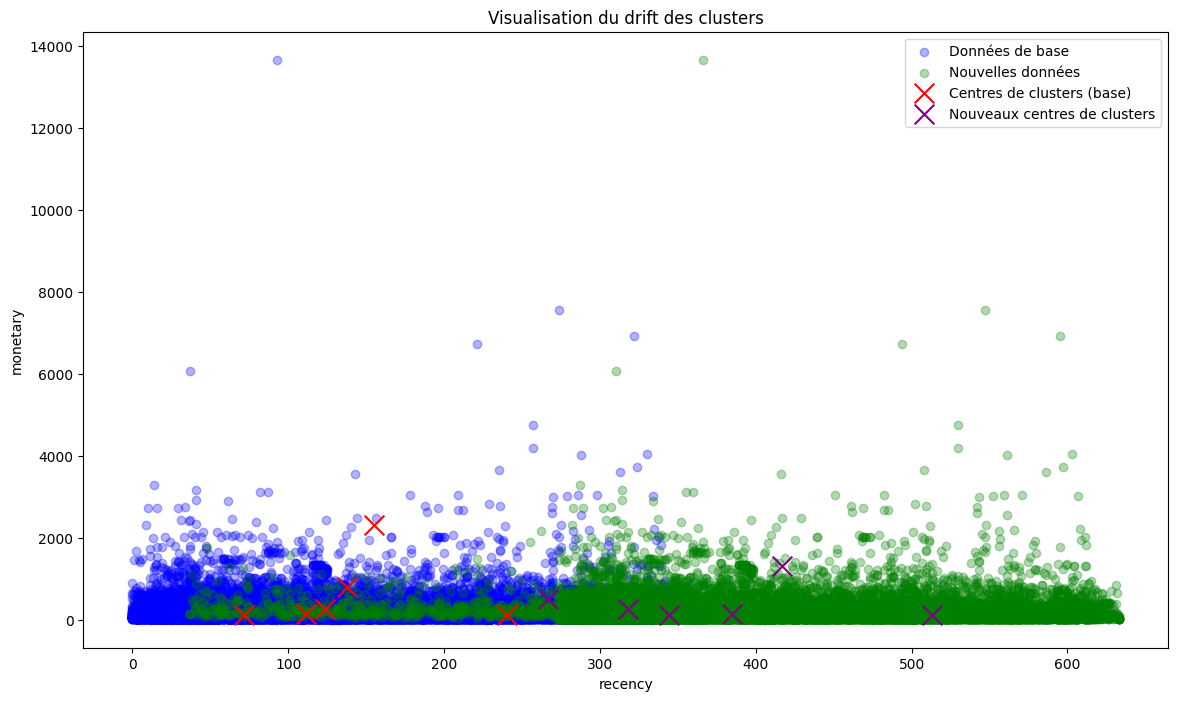

CPU times: user 6.26 s, sys: 67 ms, total: 6.33 s
Wall time: 1.91 s


In [42]:
%%time
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score
from scipy.stats import ks_2samp

def display_drift(rfm_baseline, processed_orders, end_date, feature_1='recency', feature_2='monetary'):

    rfm_new = create_rfm_df(processed_orders, end_date=end_date, verbose=False)
    
    # Align customers: use intersection of baseline and new customers for label-based comparisons
    common_customers = rfm_baseline.index.intersection(rfm_new.index)
    # print("Common Customers:", len(common_customers))
    rfm_new = rfm_new.loc[common_customers]
    # print("New RFM Shape (after alignment):", rfm_new.shape)
    X_new = scaler.transform(rfm_new[features])
    
    # Option 1: Use the baseline k-means model to assign clusters (keeps the original segmentation)
    rfm_new['cluster_baseline'] = kmeans_baseline.predict(X_new)
    
    # Option 2: Retrain a k-means on new data (to see the drift in cluster centers) 
    # Note: In production, you might not retrain until you decide to update.
    kmeans_new = KMeans(n_clusters=k, random_state=42, n_init=10)
    rfm_new['cluster_new'] = kmeans_new.fit_predict(X_new)

    # Compare cluster centers distance
    centers_new = kmeans_new.cluster_centers_
    centers_baseline = kmeans_baseline.cluster_centers_

    plt.figure(figsize=(14, 8))
    
    # Afficher les données de base non-scalées
    plt.scatter(rfm_baseline[feature_1], rfm_baseline[feature_2], c='blue', alpha=0.3, label='Données de base')
    
    # Afficher les nouvelles données non-scalées
    plt.scatter(rfm_new[feature_1], rfm_new[feature_2], c='green', alpha=0.3, label='Nouvelles données')
    
    # Afficher les centres des clusters de base
    plt.scatter(scaler.inverse_transform(centers_baseline)[:, 0], scaler.inverse_transform(centers_baseline)[:, 2], c='red', marker='x', s=200, label='Centres de clusters (base)')
    
    # Afficher les nouveaux centres des clusters
    plt.scatter(scaler.inverse_transform(centers_new)[:, 0], scaler.inverse_transform(centers_new)[:, 2], c='purple', marker='x', s=200, label='Nouveaux centres de clusters')
    
    plt.title('Visualisation du drift des clusters')
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.legend()
    plt.show()

display_drift(rfm_baseline, processed_orders, monitor_dates[2])

### Plan de maintenance

Proposer un plan de maintenance basé sur une simulation de fréquence de mise à jour du modèle.


#### Déterminer la meilleure fréquence d'entraînement

En exécutant le code de surveillance ci-dessus sur une fenêtre glissante (par exemple, tous les 3 mois), nous pouvons analyser à quelle vitesse nos métriques de dérive (inertie, silhouette, distributions des caractéristiques, déplacements des centres de clusters) changent.

Par exemple, si nous observons que des changements significatifs (dépassant nos seuils définis) se produisent chaque trimestre, alors un réentraînement trimestriel pourrait être optimal. Si la dérive est très progressive, nous pourrions étendre la fréquence de réentraînement à tous les 6 mois.

Nous pouvons également compléter ces métriques par des informations commerciales (par exemple, campagnes saisonnières, changements de produits) pour décider de la fréquence de réentraînement.


---

### Fréquence de Mise à Jour du Modèle

#### **Fréquence Recommandée :**

- **Tous les 2 à 3 mois** : Sur la base des résultats observés, une mise à jour tous les 2 à 3 mois semble appropriée. Voici pourquoi :

#### **Justification :**

1. **Stabilité et Dérive des Clusters** :
   - Les clusters sont restés relativement stables sur des périodes de 2 à 3 mois, avec des fluctuations mineures. Cependant, une dérive significative a été observée après environ 4 mois (en mai 2018), nécessitant un réentraînement.

2. **Changements dans les Métriques** :
   - Des changements significatifs dans les métriques comme l'inertie, le silhouette score, l'ARI, l'homogénéité, et la complétude ont été observés après 4 mois, indiquant une détérioration de la qualité du clustering.

3. **Distribution des Caractéristiques** :
   - Le test KS a montré des changements significatifs dans la distribution des caractéristiques, notamment la "recency", ce qui justifie une mise à jour pour s'adapter à ces nouvelles distributions.

4. **Équilibre entre Stabilité et Réactivité** :
   - Une mise à jour tous les 2 à 3 mois permet de maintenir un équilibre entre la stabilité des clusters et la réactivité aux changements dans les données. Cela permet également de minimiser les coûts et les efforts associés à des mises à jour trop fréquentes.

#### **Conclusion :**

Une fréquence de mise à jour tous les 2 à 3 mois permet de capturer les changements significatifs dans les données tout en maintenant la pertinence et l'efficacité du modèle de segmentation. Cela garantit que les clusters restent cohérents et représentatifs des tendances actuelles des données.